# PPV_LAW
Código para determinar la ley de propagación de vibraciones en el terreno a
partir del registro en voladuras de las velocidades pico de partícula (ppv)
con diferentes cargas y distancias.

Se espera que se haya definido previamente el modelo de distancia escalada
(s_d: Distancia/Carga^beta). Como ejemplo, y típicamente para cargas alargadas:
beta = 1/2, y para cargas esféricas: beta = 1/3.

En el fichero de entrada los valores x son los logaritmos decimales de
las distancias escaladas (log10(s_d)); los valores y son, consecuentemente,
los log10(ppv):  
x	y  
1.76779	0.2001  
0.69139	1.96096  
1.55308	1.06786  
..............  

Se supone modelo de ruido lognormal y ofrece, entre otros resultados, la recta
(curva) de seguridad definido un nivel de confianza nc (nc>0.5 ->50%).

Aquella se calcula tanto de de forma aproximada (recta de seguridad) como de
forma rigurosa (intervalo de predicción) -teniendo en cuenta que los parámetros del modelo son estimados. En este caso el resultado se aproxima con una ecuación cuadrática.

También calcula el intervalo de tolerancia definida la cobertura y el nivel de confianza deseado. Con el intervalo de tolerancia se "asegura" la cobertura deseada de la población con el nc establecido.


(utilidad con fines docentes)

## Establecimiento de la ruta al directorio de trabajo (W_D) y carga de los paquetes requeridos

In [1]:
import os
os.getcwd()     # Se comprueba la ruta de trabajo actual 

'c:\\Users\\usuario\\SynologyDrive\\GITHUB\\Espacios\\Vibration_Attenuation_Law'

In [2]:
# Introduzca la ruta al directorio de trabajo donde se guardarán los resultados (comente si no desea modificarla)
# W_D = r'C:\Users\usuario\works\vibrations'
# os.chdir(W_D)

In [3]:
# Carga de paquetes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.special as sp

## Función principal

In [4]:
def ppv_regress(filename, nc=0.9, cobertura=0.95, n_grid=20):
    '''Calcula la regresión lineal de la muestra (x, y)--> (log_s_d, log_v_e),
    los intervalos de predicción con un nivel de confianza nc (con nc>0.5) en
    los puntos x de los datos de entrada, y en un grid de n_grid puntos).
    Grafica y guarda los resultados, calcula la cobertura...
    Los datos de partida y cálculos realizados en escala log10
'''

    # se evita una division entre, prácticamente, 0 cuando nc=0.5
    if nc == 0.5:
        nc = 0.5001

    # lectura de los datos (x, y) a dataframe
    df_xy = pd.read_csv(filename, sep=r'\s+')
    x = df_xy['x']
    y = df_xy['y']

    # número de datos de trabajo y grid de puntos (con n_grid puntos)
    n = len(x)
    x_grid = np.linspace(np.min(x), np.max(x), n_grid)

    # regresión lineal, predicción, residuos y su desviación estándar
    slope, intercept = np.polyfit(x, y, deg=1)
    y_predict = intercept + slope*x
    rss_y = y - y_predict
    mse = np.sqrt(np.square(rss_y).sum()/(n-2))

    # cálculos intermedios para obtener el error de predicción en cada punto
    x_mean = np.mean(x)
    x_gap = x-x_mean
    ss = np.square(x_gap).sum()

    # cálculo del error (en puntos x y x_grid): método aproximado y riguroso
    # (teniendo en cuenta el error del modelo)
    se_x_aprox = st.norm.ppf(nc, loc=0, scale=mse)
    se_x = np.sqrt(1 + 1/n + np.square((x - x_mean))/ss) * \
        mse*st.t.ppf(nc, df=n-2)
    se_x_grid = np.sqrt(1 + 1/n + np.square((x_grid - x_mean))/ss) * \
        mse*st.t.ppf(nc, df=n-2)
        
    # cálculo del intervalo de tolerancia
    _x_tol = np.sqrt(1 / n + np.square((x - x_mean)) / ss)
    _x_tol_grid = np.sqrt(1 / n + np.square((x_grid - x_mean)) / ss)
    zp_d = st.norm.ppf(cobertura) / _x_tol
    zp_d_grid = st.norm.ppf(cobertura) / _x_tol_grid
    se_x_tol = sp.nctdtrit(n - 2, zp_d, nc, out=None) * mse * _x_tol
    se_x_tol_grid = sp.nctdtrit(
        n - 2, zp_d_grid, nc, out=None) * mse * _x_tol_grid

    # cáculo de predicción en x con nivel de confianza nc (ambos métodos)
    y_pred_nc_aprox = y_predict + se_x_aprox
    y_pred_nc = y_predict + se_x
    y_tol_nc = y_predict + se_x_tol
    
    # cálculo de cobertura con ambos métodos
    cover_aprox = np.mean(y_pred_nc_aprox > y)
    cover_pred = np.mean(y_pred_nc > y)
    cover_tol = np.mean(y_tol_nc > y)
    cover = (cover_aprox, cover_pred, cover_tol)
    print('la cobertura sobre la muestra es (aprox/predicción/tolerancia): ', cover)

    # se repiten los cálculos para el grid x_grid
    y_predict_x_grid = intercept + slope*x_grid
    y_pred_x_grid_nc_aprox = y_predict_x_grid + se_x_aprox
    y_pred_x_grid_nc = y_predict_x_grid + se_x_grid
    y_tol_x_grid_nc = y_predict_x_grid + se_x_tol_grid
    
    # ecuaciones de la recta/curva de seguridad con nivel de confianza nc
    # ajuste aproximado
    nc_equation_aprox = (intercept+se_x_aprox, slope)
    # ajuste del intervalo de predicción a una ecuación de segundo grado
    nc_equation_pred = np.polyfit(x_grid, y_pred_x_grid_nc, deg=2, full='true')
    print('el valor del error estándar de la regresión es: ', mse)
    print('el valor del error estándar del ajuste del intervalo de predicción a una')
    print('         ecuación de segundo grado es: ', nc_equation_pred[1]/(n_grid-2))
    # ajuste del intervalo de tolerancia a una ecuación de segundo grado
    nc_equation_tol = np.polyfit(x_grid, y_tol_x_grid_nc, deg=2, full="true")
    print('el valor del error estándar del ajuste del intervalo de tolerancia a una')
    print('         ecuación de segundo grado es: ', nc_equation_tol[1]/(n_grid-2))
    
    # gráfico de resultados sin florituras
    plt.figure(0)
    plt.plot(x, y, marker='.', linestyle='none', label='data')
    plt.plot(x_grid, y_predict_x_grid, linestyle='solid', label='regression')
    plt.plot(x_grid, y_pred_x_grid_nc_aprox,
             linestyle='dashed', label='nc_aprox')
    plt.plot(x_grid, y_pred_x_grid_nc, linestyle='solid', label='prediction')
    plt.plot(x_grid, y_tol_x_grid_nc, linestyle="solid", label="tolerance")
    plt.legend()
    plt.xlabel('log(sd)')
    plt.ylabel('log(ppv)')
    plt.margins(0.05)

    # guardado de resultados en los puntos x
    df_xy['y_pred'] = y_predict
    df_xy['y_pred_nc_aprox'] = y_pred_nc_aprox
    df_xy['y_pred_nc'] = y_pred_nc
    df_xy["y_tol_nc"] = y_tol_nc
    
    # guardado de resultados en los puntos x_grid
    df_x_grid = pd.DataFrame({'x': x_grid})
    df_x_grid['y_pred'] = y_predict_x_grid
    df_x_grid['y_pred_nc_aprox'] = y_pred_x_grid_nc_aprox
    df_x_grid['y_pred_nc'] = y_pred_x_grid_nc
    df_x_grid["y_tol_nc"] = y_tol_x_grid_nc
    
    return intercept, slope, df_xy, df_x_grid, nc_equation_pred, nc_equation_aprox, nc_equation_tol

la cobertura sobre la muestra es (aprox/predicción/tolerancia):  (0.92, 0.92, 0.98)
el valor del error estándar de la regresión es:  0.23535960965034147
el valor del error estándar del ajuste del intervalo de predicción a una
         ecuación de segundo grado es:  [1.08140299e-09]
el valor del error estándar del ajuste del intervalo de tolerancia a una
         ecuación de segundo grado es:  [1.737549e-06]


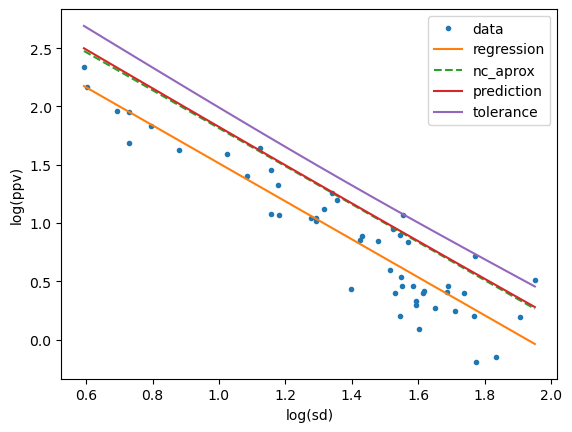

In [5]:
# Se ejecuta la función
data_ppv_v = "data_ppv_vertical.txt"
results = ppv_regress(data_ppv_v, nc=0.90, cobertura=0.95)

## Valores de y en el grid: la mediana y con un nivel de confianza nc

In [6]:
print(results[3])

           x    y_pred  y_pred_nc_aprox  y_pred_nc  y_tol_nc
0   0.593250  2.174802         2.476427   2.499444  2.691228
1   0.664739  2.058340         2.359966   2.380336  2.567436
2   0.736228  1.941879         2.243504   2.261457  2.443895
3   0.807717  1.825418         2.127043   2.142813  2.320660
4   0.879206  1.708956         2.010582   2.024410  2.197796
5   0.950695  1.592495         1.894120   1.906250  2.075386
6   1.022184  1.476034         1.777659   1.788339  1.953529
7   1.093673  1.359572         1.661198   1.670679  1.832344
8   1.165162  1.243111         1.544736   1.553274  1.711960
9   1.236651  1.126649         1.428275   1.436127  1.592514
10  1.308139  1.010188         1.311814   1.319238  1.474130
11  1.379628  0.893727         1.195352   1.202608  1.356899
12  1.451117  0.777265         1.078891   1.086239  1.240862
13  1.522606  0.660804         0.962430   0.970130  1.125995
14  1.594095  0.544343         0.845968   0.854280  1.012221
15  1.665584  0.427881  

## Coeficientes de la ecuación para un nivel de confianza nc

In [7]:
# solución aproximada
print(' sol. aprox. coeficientes de la ecuación de primer grado (a+bx): ', results[5])

 sol. aprox. coeficientes de la ecuación de primer grado (a+bx):  (3.4428799612678, -1.6290819073150211)


In [8]:
# solución intervalo de predicción
print(' sol. int. predicción coeficientes de la ecuación de segundo grado (a+bx+cx^2): ', np.flip(results[4][0]))

 sol. int. predicción coeficientes de la ecuación de segundo grado (a+bx+cx^2):  [ 3.49832387 -1.69840166  0.02494465]


In [9]:
# solución intervalo de tolerancia
print(' sol. int. tolerancia coeficientes de la ecuación de segundo grado (a+bx+cx^2): ', np.flip(results[6][0]))

 sol. int. tolerancia coeficientes de la ecuación de segundo grado (a+bx+cx^2):  [ 3.77370997 -1.87169144  0.08768721]


## Función auxiliar para crear una tabla de carga operante frente a distancia a partir de los resultados de la función ppv_regress

In [10]:
def cargas_sd(nc_equation_pred, nc_eq_aprox, nc_equation_tol, d_grid=range(40, 200), ppvumb=40, beta=0.5):
    ''' Cálculo de las cargas máximas operantes (vg. en Q kg) en función de las
    distancias (d_grid, vg. D en m) definido un valor umbral de la ppv
    (vg. mm/s) y el valor de beta de la ley de escala empleada:
    s_d: Distancia/Carga^beta.
    Se emplean el modelo riguroso y el aproximado
'''

    # resolución de la ecuación de segundo grado para solución int. predicción
    logppv = np.log10(ppvumb)
    a = nc_equation_pred[0]
    b = nc_equation_pred[1]
    c = nc_equation_pred[2]-logppv
    # raíz menor
    logsd_pred = (-b - np.sqrt((b * b) - 4 * a * c))/(2 * a)
    sd = 10**logsd_pred
    # cálculo de las cargas
    cargas_prediccion = np.power(d_grid/sd, 1/beta)

    # cálculo de las cargas para solución aproximada
    logsd_aprox = (-nc_eq_aprox[0]+logppv)/nc_eq_aprox[1]
    sd_aprox = 10**logsd_aprox
    carga_aprox = np.power(d_grid/sd_aprox, 1/beta)

    # resolución de la ecuación de segundo grado para solución con int. de tolerancia
    a = nc_equation_tol[0]
    b = nc_equation_tol[1]
    c = nc_equation_tol[2] - logppv
    # raíz menor
    logsd_tol = (-b - np.sqrt((b * b) - 4 * a * c)) / (2 * a)
    sd_tol = 10**logsd_tol
    # cálculo de las cargas para la solución con intervalo de tolerancia
    cargas_tolerancia = np.power(d_grid / sd_tol, 1 / beta)

    # gráfico de resultados
    plt.figure(1)
    plt.plot(d_grid, cargas_prediccion, linestyle='solid', label='Qpred vs D')
    plt.plot(d_grid, carga_aprox, linestyle='dashed', label='Qaprox vs D')
    plt.plot(d_grid, cargas_tolerancia, linestyle="solid", label="Qtol vs D")
    plt.legend()
    plt.xlabel('Distancia (D m)')
    plt.ylabel('Carga (Q kg)')
    plt.margins(0.05)

    # se almacenan los resultados en un dataframe
    df_QvsD = pd.DataFrame({'D': d_grid})
    df_QvsD['Q'] = cargas_prediccion
    df_QvsD['Qaprox'] = carga_aprox
    df_QvsD["Qtolerancia"] = cargas_tolerancia

    return df_QvsD, logsd_pred, logsd_tol

## Se definen la velocidad umbral, el rango de distancias y el valor de beta del modelo

In [11]:
# ejemplo con velocidad umbral de 40 mm/s, rango de distancias emtre: 50m y 250m y ley de escala cuadrática
ppvumb = 40
dgrid = np.linspace(50, 250, 20)
beta = 0.5

# Se ejecuta la función para obtener Q frente D y el log10(sd) correspondiente

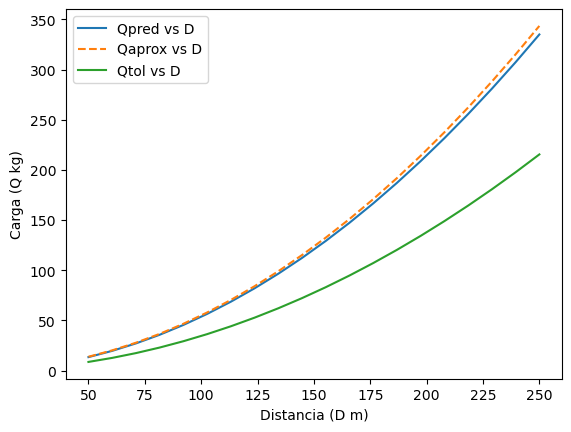

In [12]:
tabla_Q_D, log_sd_pred, log_sd_tol = cargas_sd(results[4][0], results[5], results[6][0], dgrid, ppvumb, beta)

In [13]:
print(tabla_Q_D)

             D           Q      Qaprox  Qtolerancia
0    50.000000   13.398996   13.740176     8.617187
1    60.526316   19.634541   20.134496    12.627402
2    71.052632   27.057807   27.746782    17.401467
3    81.578947   35.668797   36.577033    22.939382
4    92.105263   45.467509   46.625250    29.241148
5   102.631579   56.453944   57.891433    36.306764
6   113.157895   68.628101   70.375582    44.136230
7   123.684211   81.989981   84.077696    52.729547
8   134.210526   96.539584   98.997776    62.086715
9   144.736842  112.276909  115.135822    72.207732
10  155.263158  129.201958  132.491834    83.092600
11  165.789474  147.314728  151.065811    94.741319
12  176.315789  166.615222  170.857754   107.153888
13  186.842105  187.103438  191.867663   120.330307
14  197.368421  208.779377  214.095537   134.270577
15  207.894737  231.643038  237.541378   148.974697
16  218.421053  255.694423  262.205183   164.442667
17  228.947368  280.933530  288.086955   180.674488
18  239.4736

In [14]:
print('el valor del log10(sd) predicción/tolerancia es = ', log_sd_pred, log_sd_tol)

el valor del log10(sd) predicción/tolerancia es =  1.1354338681725789 1.2312872396955639


## Tenga en cuenta que log10(sd) debe estar en el rango de los datos (x)

In [15]:
df = (results[3])
print('el valor de log10(sd) de los datos varía entre ', df['x'][0], 'y ', df.at[df.index[-1], "x"])

el valor de log10(sd) de los datos varía entre  0.59325 y  1.95154
